In [1]:
from IPython.display import HTML

# %%javascript block returns some strange representation of IPython
# Javascript object and displays it in the blog post. For this reason
# it's better to put JS code in HTML DOM
HTML("""
<script type="text/javascript">
require(['base/js/utils'],
function(utils) {
   utils.load_extensions('calico-spell-check',
                         'calico-document-tools',
                         'calico-cell-tools');
});
</script>
""")

Some time ago I came across one book called [Street-Fight Mathematics](https://mitpress.mit.edu/books/street-fighting-mathematics). I found it extremely interesting and useful. It consists only of 150 pages, but it covers a lot of awesome problem solving techniques. You can actually download the book for free or buy it, though there's a free copy available it's still worth paying.

There's one particular problem in this book that caught my attention. It is Standard Normal Distribution CDF approximation. If you check the [Wikipedia](https://en.wikipedia.org/wiki/Normal_distribution#Numerical_approximations_for_the_normal_CDF) you will find that many solutions can be used to produce extremely accurate approximation. I checked proofs for two of them and I found that they include some amount of calculus which can be challenging for some people. But methods from the book don't require calculus knowledge to make such an approximation. We don't even need to get into advanced maths, just heuristics and simple math operations. So, let's look at the solution step by step.

First of all let's check the Standard Gaussian PDF \\((1)\\).

$$
f(x) = \frac{1}{\sqrt{2 \pi}} \cdot e ^ {\frac{-x ^ 2}{2}}
\tag 1
$$

In [2]:
import warnings
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
warnings.simplefilter("ignore")

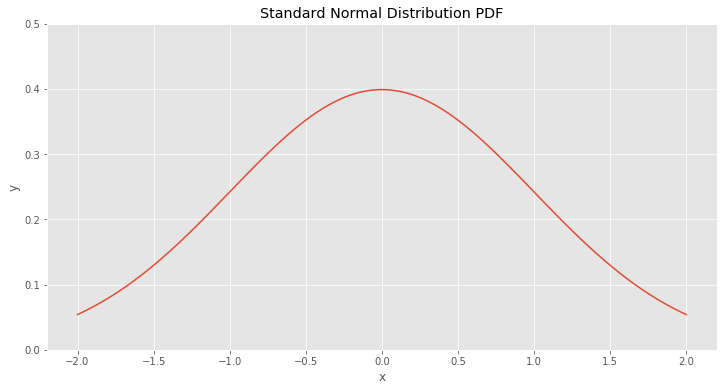

In [3]:
x = np.linspace(-2, 2, 100)
y = norm.pdf(x)

plt.figure(figsize=(12, 6))
plt.title("Standard Normal Distribution PDF")
plt.xlabel("x")
plt.ylabel("y")
plt.plot(x, y)
plt.ylim(0, 0.5)
plt.show()

For the gaussian (the figure above) we need to find a function that returns area under the PDF function for \\(x \in (-\infty, a]\\) where \\(a \in \Bbb R\\). In other words it's a CDF \\((2)\\).

$$
\begin{align}
F(x) & = \int _ {-\infty} ^ {x} f(t) \;dt \\\\
 & = \frac{1}{\sqrt{2 \pi}} \int _ {-\infty} ^ {x} e ^ {\frac{-t ^ 2}{2}} \;dt
\end{align}
\tag{2}
$$

Let's plot it next.

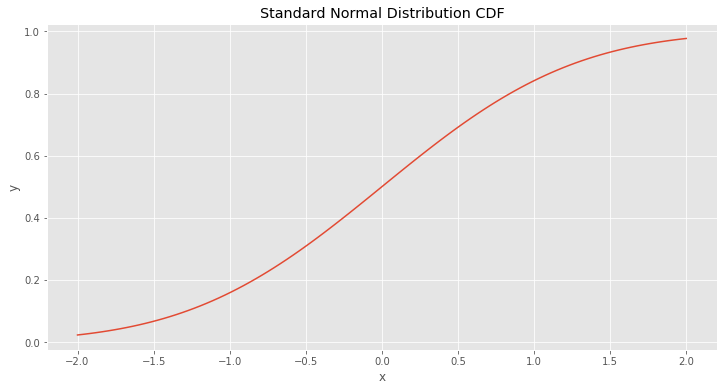

In [4]:
def plot_gaussian_cdf(x):
    plt.figure(figsize=(12, 6))
    plt.xlabel("x")
    plt.ylabel("y")
    return plt.plot(x, norm.cdf(x))

x = np.linspace(-2, 2, 100)
plot_gaussian_cdf(x)
plt.title("Standard Normal Distribution CDF")
plt.show()

The problem is that there is no [elementary function](https://en.wikipedia.org/wiki/Elementary_function) that can perfectly fit function that is shown above. A good news is that, we can approximate it. In real life applications we don't need the exact answer, we just interested in a very close one.

From the previous figure it is clear that function is [odd](https://en.wikipedia.org/wiki/Even_and_odd_functions#Odd_functions). Therefore, we can compute only the half of CDF where \\(x \in (-\infty, 0]\\) and using function's symmetry to find the rest.

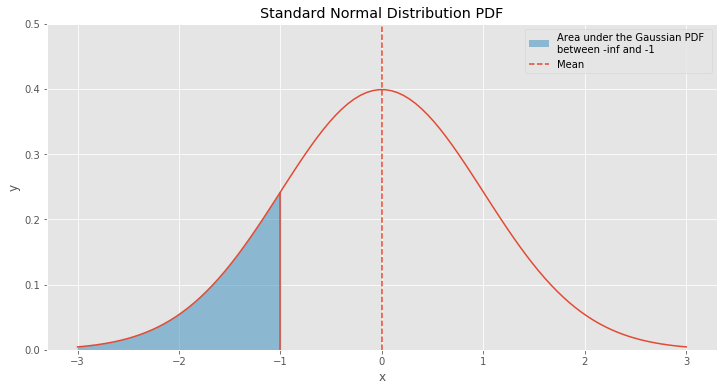

In [6]:
colors = [value['color'] for value in plt.rcParams['axes.prop_cycle']]
red = colors[0]
blue = colors[1]

n_samples = 100
x = np.linspace(-3, 3, n_samples)
y = norm.pdf(x)
blue_area_right_bound = -1

plt.figure(figsize=(12, 6))

plt.vlines(blue_area_right_bound, 0, norm.pdf(blue_area_right_bound), color=red)
pdf_mean_line = plt.vlines(0, 0, 0.5, linestyle='--', color=red)
plt.plot(x, y, color=red)

x_for_filled_region = np.linspace(-3, blue_area_right_bound, n_samples)
plt.fill_between(
    x_for_filled_region,
    np.zeros(n_samples),
    norm.pdf(x_for_filled_region),
    alpha=0.5,
    color=blue
)

plt.title("Standard Normal Distribution PDF")
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(0, 0.5)

plt.legend(
    [
        plt.Rectangle((0, 0), 1, 1, fc=blue, alpha=0.5),
        pdf_mean_line
    ],
    [
        'Area under the Gaussian PDF \nbetween -inf and -1',
        'Mean'
    ],
    loc='upper right'
)
plt.show()

Let's think a little bit about the problem. What do we actually need? We need to find the area. Which 2D object has the most simple formula for the area? It's a rectangle. To find it we just need to multiply width by height. Let's try to find rectangle that approximates the CDF. In the figure below pictured the same Gaussian PDF, as in the previous figure, but only for \\(x \in [-3, 0]\\).

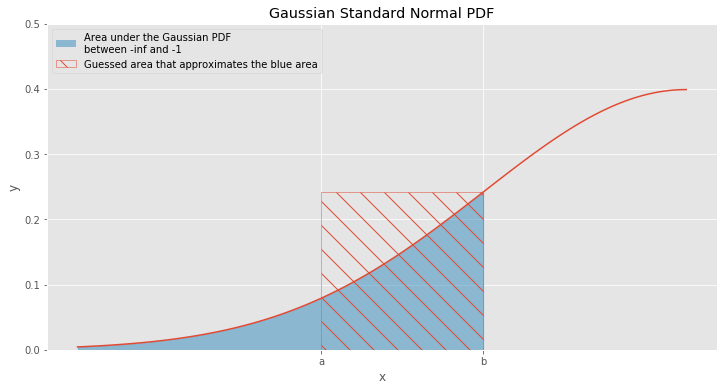

In [8]:
from matplotlib.patches import Polygon

red = colors[0]
blue = colors[1]

n_samples = 100
x = np.linspace(-3, 0, 100)
pdf_real = norm.pdf(x)
blue_area_right_bound = -1
guessed_left_bound = -1.8
blue_area_right_bound_pdf = norm.pdf(blue_area_right_bound)

plt.figure(figsize=(12, 6))

approx_rect_area, = plt.fill(
    [
        guessed_left_bound, blue_area_right_bound,
        blue_area_right_bound, guessed_left_bound
    ],
    [0, 0, blue_area_right_bound_pdf, blue_area_right_bound_pdf],
    fill=False,
    hatch='\\',
    color=red
)

plt.plot(x, pdf_real, color=red)

x_for_filled_region = np.linspace(-3, blue_area_right_bound, n_samples)
plt.fill_between(
    x_for_filled_region,
    np.zeros(n_samples),
    norm.pdf(x_for_filled_region),
    alpha=0.5,
    color=blue
)

plt.title("Gaussian Standard Normal PDF")
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(0, 0.5)

plt.xticks([guessed_left_bound, blue_area_right_bound], ['a', 'b'])

plt.legend(
    [
        plt.Rectangle((0, 0), 1, 1, fc=blue, alpha=0.5),
        approx_rect_area
    ],
    [
        'Area under the Gaussian PDF \nbetween -inf and -1',
        'Guessed area that approximates the blue area'
    ],
    loc='upper left'
)
plt.show()

In the figure above you can find a rectangle filled with oblique lines. This rectangle got the biggest part of the blue area. In addition, it also caught a lot of region that is under the curve and didn't catch an infinitely long "tail" on the left. We can think about this rectangle in more intuitive way. Let's say that we have a box and we would like to fill it with some long cloth. We already put the biggest part of the cloth and now we need to place the rest of it inside. Since we have  some space left, we can fill it with the rest of the cloth.

There are two heuristics that can determine box's width and height. The first method that we are going to use is a **\\(1 / e\\) heuristic**. The main idea of this heuristic is the need to find a point \\(x\\) that identifies significant changes of function. There is no clear definition of "significant change" that's why we need some rule that can help us identify something that is close to it. For the 1 / e heuristic function's significant change means that function minimizes its maximum value by factor of \\(e\\).

$$
f(a) = \frac{1}{e} \cdot f(b)
\tag 3
$$

Where \\(b\\) is the value that identifies right bound for the that approximates function that we're interested in. And \\(a\\) is the point that identifies function's significant change. \\(a\\) is also the left side bound for this rectangle. Gaussian PDF is monotonically increasing for \\(x \in (-\infty, 0]\\), therefore, the maximum value \\(x\\) identifies function's maximum. We can detect it using simple algebraic operations.

$$
\frac{1}{\sqrt{2 \pi}} \cdot e ^ {\frac{-a ^ 2}{2}} = \frac{1}{e} \cdot \frac{1}{\sqrt{2 \pi}} \cdot e ^ {\frac{-b ^ 2}{2}}
\tag 4
$$

$$
e ^ {\frac{-a ^ 2}{2}} = \frac{1}{e}\cdot e ^ {\frac{-b ^ 2}{2}}
\tag 5
$$

$$
e ^ {\frac{-a ^ 2}{2}} = e ^ {\frac{-b ^ 2}{2} - 1}
\tag 6
$$

$$
e ^ {\frac{-a ^ 2}{2}} = e ^ {\frac{-b ^ 2 - 2}{2}}
\tag 7
$$

$$
a ^ 2 = b ^ 2 + 2
\tag 8
$$

$$
a = \pm \sqrt{b ^ 2 + 2}
\tag 9
$$

Since \\(a < 0\\),

$$
a = - \sqrt{b ^ 2 + 2}
\tag{10}
$$

Now we are able to find the \\(1 / e\\) heuristic's CDF approximation.

$$
\begin{align}
F(x) & \approx \Phi_e(x) \\\\
 & = (b - a) \cdot f(x) \\\\
 & = (x - (-\sqrt{x ^ 2 + 2})) \cdot f(x) \\\\
 & = \frac{1}{\sqrt{2 \pi}} \cdot (x + \sqrt{x ^ 2 + 2}) \cdot e ^ {\frac{-x ^ 2}{2}}
\end{align}
\tag{11}
$$

Formula \\((11)\\) is a rough approximation for the Gaussian CDF. We can plot approximation and compare it to the real CDF function.

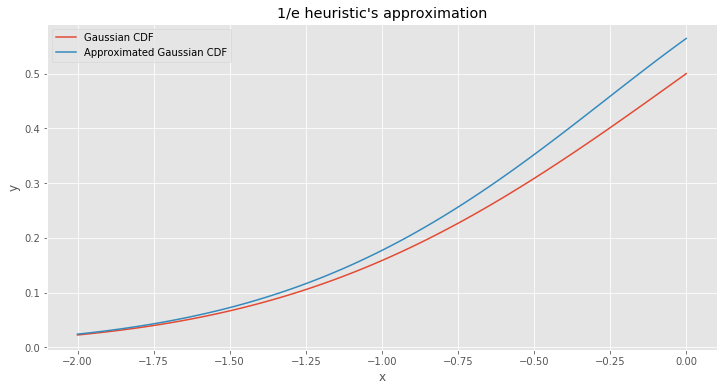

In [9]:
def half_cdf_e_heuristic_approx(x):
    scaler = 1 / np.sqrt(2 * np.pi)
    return scaler * (x + np.sqrt(x ** 2 + 2)) * np.exp(-x**2 / 2)

def plot_gaussian_cdf_approx(x, cdf_approx_func):
    cdf_real_line, = plot_gaussian_cdf(x)
    cdf_approx_line, = plt.plot(x, cdf_approx_func(x))

    plt.legend(
        [cdf_real_line, cdf_approx_line],
        ['Gaussian CDF', 'Approximated Gaussian CDF'],
        loc='upper left'
    )

plot_gaussian_cdf_approx(
    np.linspace(-2, 0, 100),
    half_cdf_e_heuristic_approx
)
plt.title("1/e heuristic's approximation")
plt.show()

Not bad for such a simple technique. It seems like this method overestimates the real value. It happened because we set up rectangle width to big. Let's check another heuristic known as **Full width at half maximum** or **FWHM**. The idea is the same as for \\(1 / e\\) heuristic, but instead of the factor \\(e\\) it uses a factor of \\(2\\). We need to perform the same calculations as we did for the heuristic above and repeat the same steps from \\((4)\\) to \\((10)\\). I didn't want to repeat  the same calculations again so I only wrote the final result.

$$
a = - \sqrt{b ^ 2 + 2 \cdot ln(2)}
\tag{18}
$$
 
$$
\begin{align}
F(x) & \approx \Phi_{fwhm}(x) \\\\
& = \frac{1}{\sqrt{2 \pi}} \cdot (x + \sqrt{x ^ 2 + 2 \cdot ln(2)}) \cdot e ^ {\frac{-x ^ 2}{2}}
\end{align}
\tag{19}
$$

Let's check the new approximation.

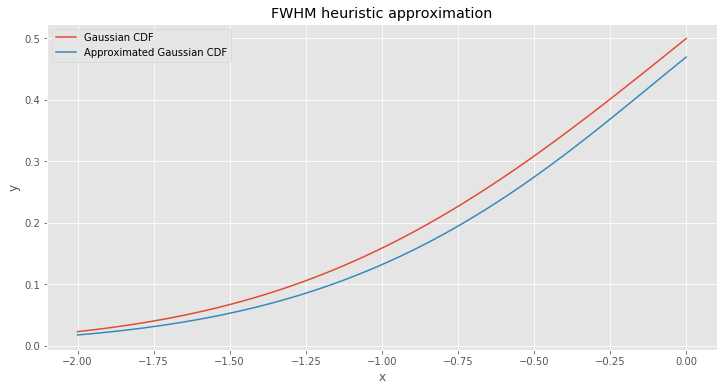

In [10]:
def half_cdf_fwhm_heuristic_approx(x):
    scaler = 1 / np.sqrt(2 * np.pi)
    return scaler * (x + np.sqrt(x ** 2 + 2 * np.log(2))) * np.exp(-x**2 / 2)

plot_gaussian_cdf_approx(
    np.linspace(-2, 0, 100),
    half_cdf_fwhm_heuristic_approx
)
plt.title("FWHM heuristic approximation")
plt.show()

Still not bad. But this time the result is an underestimate. Now we have two solutions that have different error signs, therefore, we can average them to reduce approximation error.

$$
\Phi _ {avg}(x) = \frac{\Phi _ e(x) + \Phi _ {fwhm}(x)}{2}
\tag{20}
$$

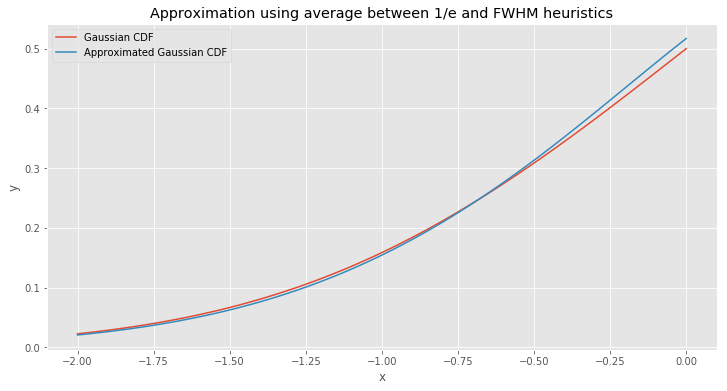

In [11]:
def half_cdf_approx(x):
    return (
        half_cdf_e_heuristic_approx(x) +
        half_cdf_fwhm_heuristic_approx(x)
    ) / 2

plot_gaussian_cdf_approx(np.linspace(-2, 0, 100), half_cdf_approx)
plt.title("Approximation using average between 1/e and FWHM heuristics")
plt.show()

Isn't it awesome? Such a simple algebraic method produces such an accurate result.

But that's not all. We just approximated a half of the Gaussian CDF, but the main task is to find an entire CDF approximation. Since the function has a symmetry we can copy and rotate \\(\Phi_{avg}\\) function to \\(x > 0\\).

$$
\Phi_{1}(x) =
\begin{cases}
\Phi_{avg}(x),  & \text{if $x \le 0$} \\\\
1 - \Phi _ {avg}(-x), & \text{otherwise}
\end{cases}
\tag{21}
$$

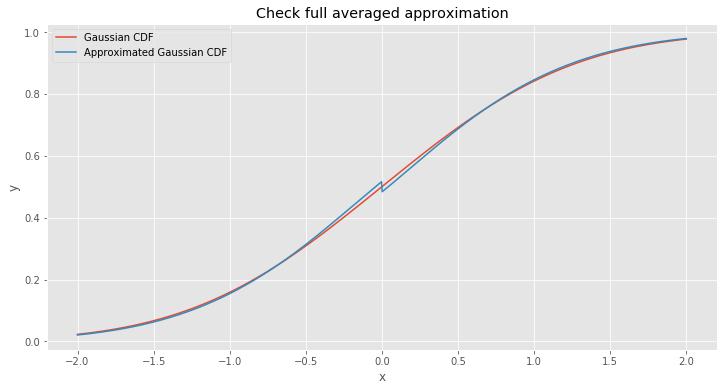

In [12]:
def cdf_approx_full(x):
    return np.where(
        x <= 0,
        half_cdf_approx(x),
        1 - half_cdf_approx(-x)
    )

plot_gaussian_cdf_approx(np.linspace(-2, 2, 1000), cdf_approx_full)
plt.title("Check full averaged approximation")
plt.show()

The strange leap at zero mark looks ugly. But why did it happen? The problem is that we expect that \\(g(0) = 0.5\\). But with our approximation we have different value for \\(x = 0\\) when we approach it from different sides. From the left side function approaches to \\(\approx 0.517\\) and from the right side - to \\(\approx 0.483\\). We can cut CDF approximation result and set up everything that greater then \\(0.5\\) equal to \\(0.5\\). Let's try it.

$$
\Phi_2(x) =
\begin{cases}
\Phi _ {avg}(x), & \text{if $x \le 0$ and $\Phi _ {avg}(x) < 0.5$} \\\\
1 - \Phi _ {avg}(-x),  & \text{if $x > 0$ and $\Phi _ {avg}(-x) < 0.5$} \\\\
0.5,  & \text{otherwise}
\end{cases}
\tag{22}
$$

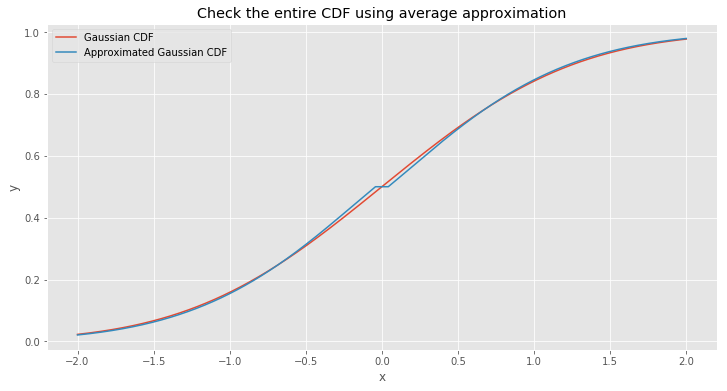

In [13]:
def cdf_cutted_approx_full(x):
    return np.where(
        x <= 0,
        np.clip(half_cdf_approx(x), 0, 0.5),
        1 - np.clip(half_cdf_approx(-x), 0, 0.5)
    )

plot_gaussian_cdf_approx(np.linspace(-2, 2, 1000),
                         cdf_cutted_approx_full)
plt.title("Check the entire CDF using average approximation")
plt.show()

Looks better. But still this junction at \\(x = 0\\) looks strange.

Now I'm going to reduce the approximation error. This procedure involves approximation error calculation from CDF that we used for comparison before. Typically, it's not possible to identify this error for each value of \\(x\\), the way we continue solving this problem will include some additional information about function which can be inaccessible for dealing with other tasks.

To reduce the approximation error we need to understand the nature of the error. It helps us compute the difference between the real CDF and its approximation. In the figure below you can spot this difference.

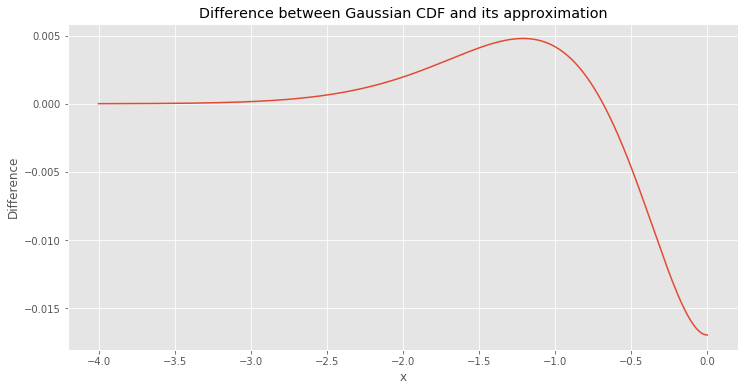

In [14]:
x = np.linspace(-4, 0, 10000)

plt.figure(figsize=(12, 6))
plt.title("Difference between Gaussian CDF and its approximation")
plt.ylabel("Difference")
plt.xlabel("x")
plt.plot(x, (norm.cdf(x) - cdf_approx_full(x)))
plt.show()

As we can see from the figure above, the biggest error is in the region \\([-2.5, 0]\\). To fix this problem we need to guess the function that can fit the one plotted above. If we knew what function can match the one above, we would be able to add it to the CDF approximation. This particular trick could help us reduce the approximation error. But the function above is definitely not the simplest one to guess.

Let's give this problem a try. What do we know about this function so far. It seems like function should have an [asymptote](https://en.wikipedia.org/wiki/Asymptote) approaches to \\(0\\). What else? Probably the function should have a nice and smooth junction at point \\(x = 0\\) which is \\(\Phi_{avg}(0)\\).

I started with a function that suited previous two observations. It is an inverse tangent (or arctangent). I know that it looks completely different, but at least it can reduce the biggest part of error.

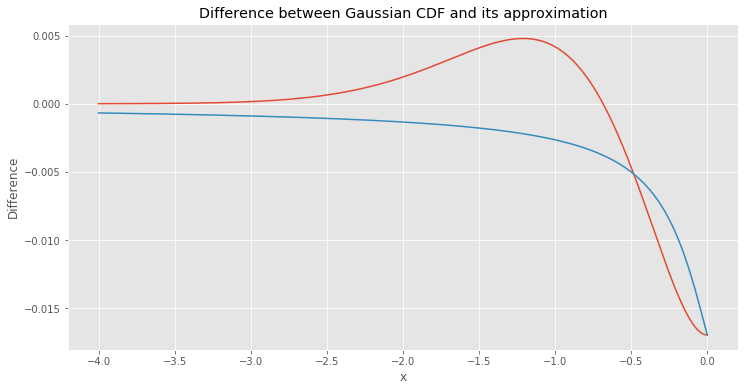

In [15]:
x = np.linspace(-4, 0, 10000)

err = norm.cdf(x) - cdf_approx_full(x)
biggest_error = min(err)

plt.figure(figsize=(12, 6))
plt.title("Difference between Gaussian CDF and its approximation")
plt.ylabel("Difference")
plt.xlabel("x")
plt.plot(x, err)
plt.plot(x, -biggest_error * np.arctan(-4 * x) / (np.pi / 2) + biggest_error)
plt.show()

The inverse tangent fuction helped us reduce the biggest error, but we can do better. After some research I found that this function above looks very similar to the second derivative of the hyperbolic tangent function, which is a common choice for activation function in Artificial Neural Networks.

$$
{d ^ 2 \over dx ^ 2} tanh(x) = -2 \cdot tanh(x) \cdot sech ^ 2(x)
\tag{23}
$$

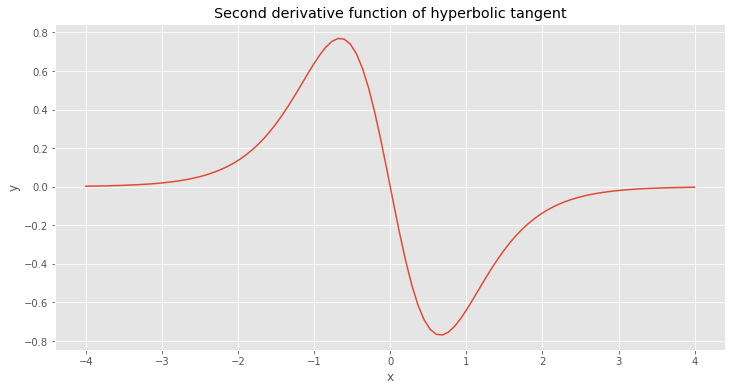

In [16]:
def tanh_second_deriv(x):
    return -2 * np.tanh(x) / np.cosh(x) ** 2

x = np.linspace(-4, 4, 100)
plt.figure(figsize=(12, 6))
plt.title("Second derivative function of hyperbolic tangent")
plt.ylabel("y")
plt.xlabel("x")
plt.plot(x, tanh_second_deriv(x))
plt.show()

It looks good as for second guess, but we definetly need to stretch it a bit. I iteratively guessed parameter values, just to make this process as quick and simple as possible. It took just a few minutes. All iterations can be viewed in the next figure.

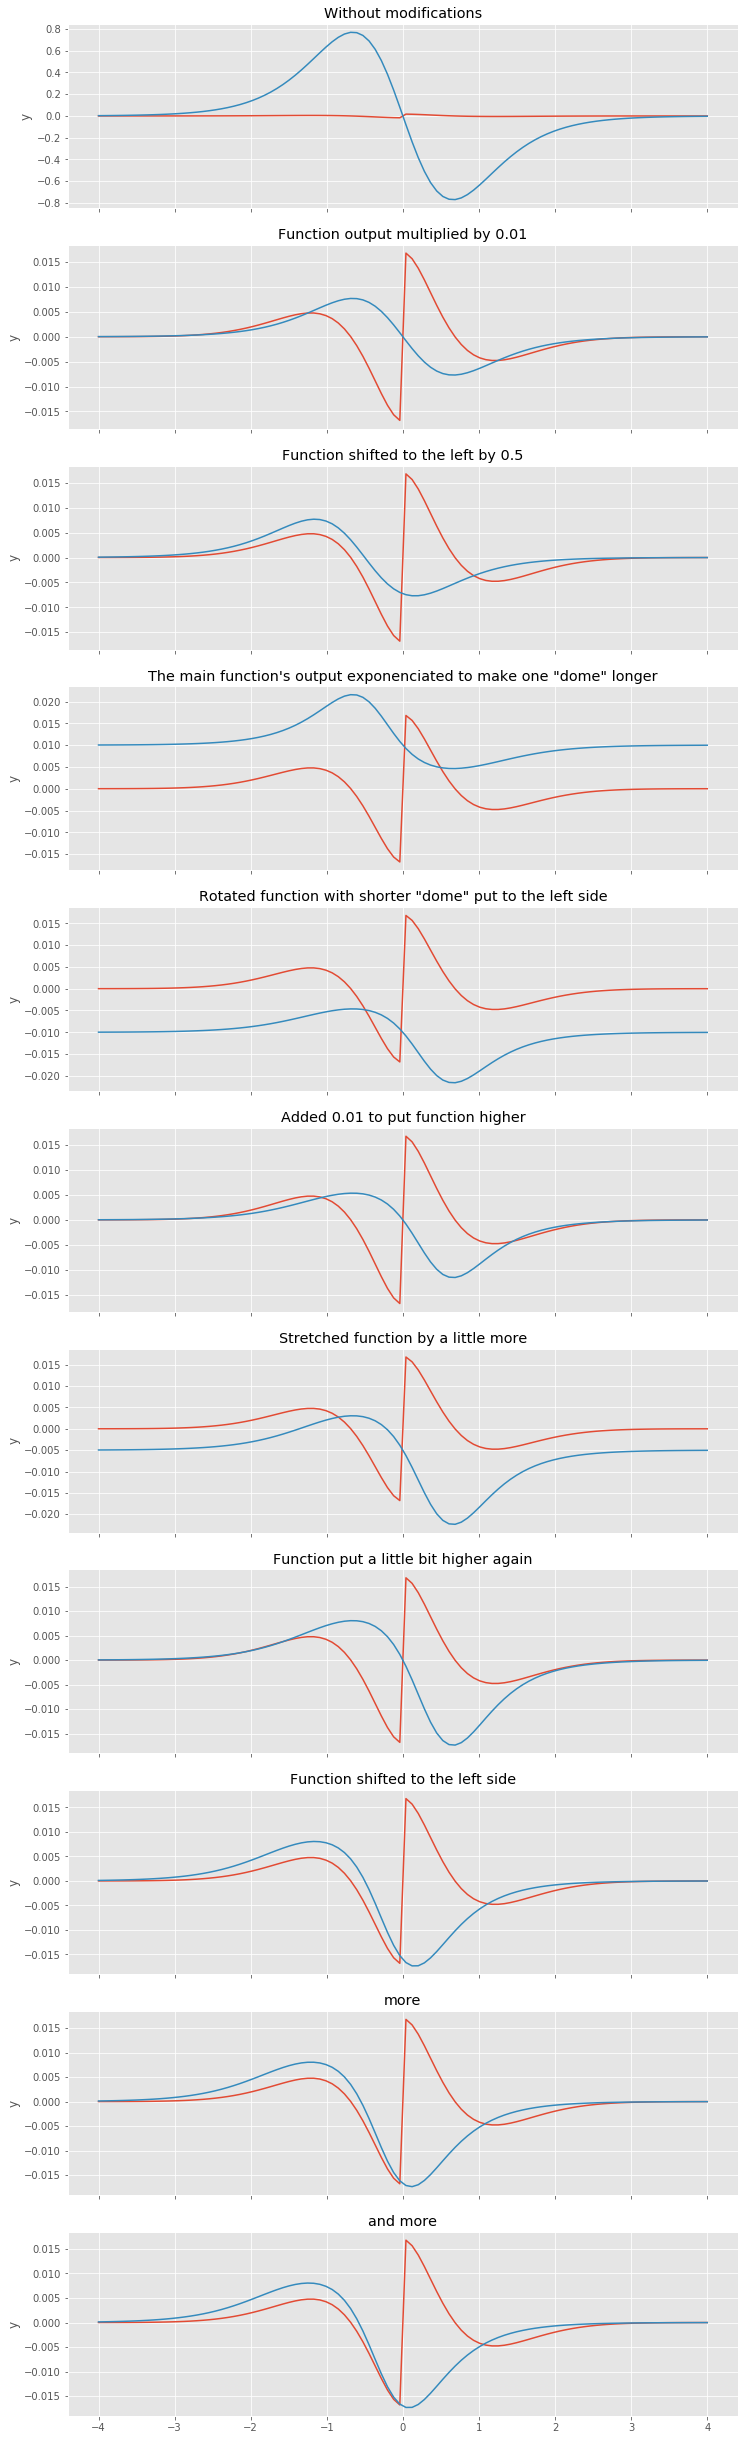

In [17]:
from collections import namedtuple

GuessingStep = namedtuple('GuessingStep', 'func description')
guesses = [
    GuessingStep(
        func=lambda x: tanh_second_deriv(x),
        description='Without modifications',
    ),
    GuessingStep(
        func=lambda x: 0.01 * tanh_second_deriv(x),
        description='Function output multiplied by 0.01',
    ),
    GuessingStep(
        func=lambda x: 0.01 * tanh_second_deriv(x + 0.5),
        description='Function shifted to the left by 0.5',
    ),
    GuessingStep(
        func=lambda x: 0.01 * np.exp(tanh_second_deriv(x)),
        description='The main function\'s output exponenciated to make one "dome" longer',
    ),
    GuessingStep(
        func=lambda x: -0.01 * np.exp(tanh_second_deriv(-x)),
        description='Rotated function with shorter "dome" put to the left side',
    ),
    GuessingStep(
        func=lambda x: -0.01 * np.exp(tanh_second_deriv(-x)) + 0.01,
        description='Added 0.01 to put function higher',
    ),
    GuessingStep(
        func=lambda x: -0.015 * np.exp(tanh_second_deriv(-x)) + 0.01,
        description='Stretched function by a little more',
    ),
    GuessingStep(
        func=lambda x: -0.015 * np.exp(tanh_second_deriv(-x)) + 0.015,
        description='Function put a little bit higher again',
    ),
    GuessingStep(
        func=lambda x: -0.015 * np.exp(tanh_second_deriv(-x - 0.5)) + 0.015,
        description='Function shifted to the left side',
    ),
    GuessingStep(
        func=lambda x: -0.015 * np.exp(tanh_second_deriv(-x - 0.55)) + 0.015,
        description='more',
    ),
    GuessingStep(
        func=lambda x: -0.015 * np.exp(tanh_second_deriv(-x - 0.58)) + 0.015,
        description='and more',
    ),
]

n_guesses = len(guesses)
x = np.linspace(-4, 4, 100)
err = norm.cdf(x) - cdf_approx_full(x)
err_min = min(err)

fig, axes = plt.subplots(n_guesses, figsize=(12, 4 * n_guesses), sharex=True)

for ax, guess in zip(axes, guesses):
    y = guess.func(x)

    ax.set_ylabel('y')
    ax.set_title(guess.description)
    ax.plot(x, err)
    ax.plot(x, y)

plt.show()

Looks like the last one suits our needs just fine. The final formula \\((23)\\) is shown below.

$$
r(x) = -0.015 \cdot exp ^ {-2 \cdot tanh(-x - 0.58) \cdot sech ^ 2(-x - 0.58)} + 0.015
\tag{24}
$$

I added this function to the last approximation \\((22)\\) and that's what I got.

$$
\Phi_3(x) =
\begin{cases}
\Phi _ {avg}(x) + r(x),  & \text{if $x \le 0$ and $\Phi _ {avg}(x) + r(x) < 0.5$} \\\\
1 - \Phi _ {avg}(-x) - r(-x),  & \text{if $x > 0$ and $\Phi _ {avg}(-x) + r(-x) < 0.5$} \\\\
0.5,  & \text{otherwise}
\end{cases}
\tag{25}
$$

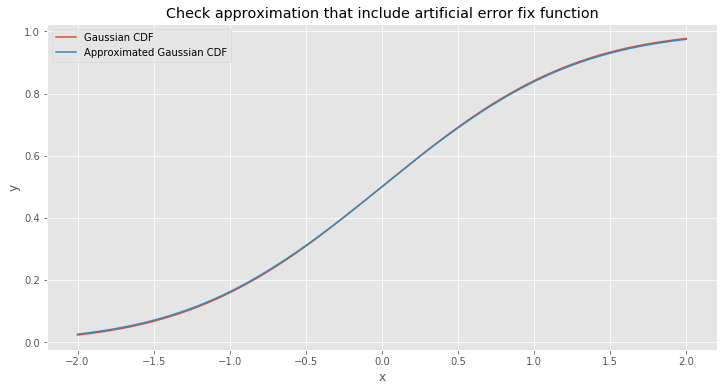

In [18]:
def guessed_error(x):
    return -0.015 * np.exp(tanh_second_deriv(-x - 0.58)) + 0.015
    
def cdf_approx_full(x):
    return np.where(
        x <= 0,
        np.clip(half_cdf_approx(x) + guessed_error(x), 0, 0.5),
        1 - np.clip(half_cdf_approx(-x) + guessed_error(-x), 0, 0.5)
    )

plot_gaussian_cdf_approx(np.linspace(-2, 2, 1000), cdf_approx_full)
plt.title("Check approximation that include artificial error fix function")
plt.show()

Awesome! Looks like it fit very well. Even though with this approximation we have one problem. There are some areas with a huge error. This problem is not very visible in the picture above but it does exist. But if we take a look at small values of \\(y\\) we will notice that error is very obvious down there. The problem is that guessed function error approximates \\(y = 0\\) much slower than the CDF and difference can be even hundreds times bigger for very small values. Below I plotted a percentage of error for the values between -5 and 5.

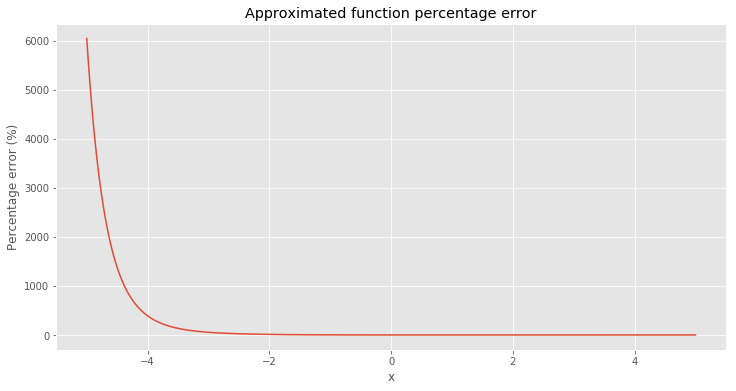

In [19]:
x = np.linspace(-5, 5, 10000)
err = np.abs(cdf_approx_full(x) - norm.cdf(x)) / norm.cdf(x)

plt.figure(figsize=(12, 6))
plt.plot(x, 100 * err)
plt.ylim()
plt.title("Approximated function percentage error")
plt.ylabel("Percentage error (%)")
plt.xlabel("x")
plt.show()

For example, value for \\(-10\\) approximately equals to \\(8 \cdot 10 ^ {-10}\\) and real CDF value for the same point is approximately \\(7.6 \cdot 10 ^ {-24}\\). In most cases we won't care about such small numbers. The easiest way to fix that problem is to cut a tail from the guessed error function.

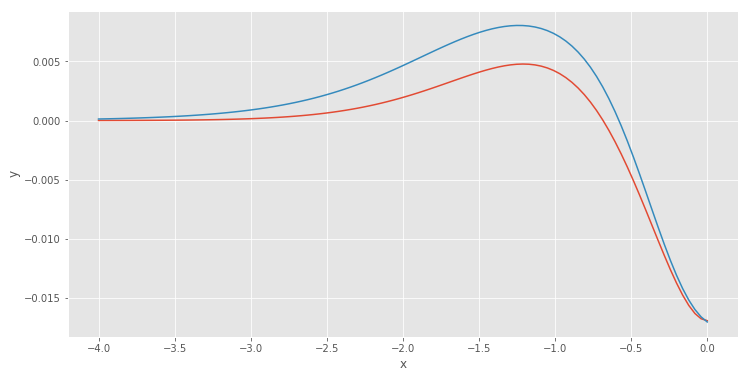

In [20]:
def old_cdf_approx_full(x):
    return np.where(
        x <= 0,
        half_cdf_approx(x),
        1 - half_cdf_approx(-x)
    )

x = np.linspace(-4, 0, 100)
err = norm.cdf(x) - old_cdf_approx_full(x)
y = guessed_error(x)

plt.figure(figsize=(12, 6))
plt.ylabel('y')
plt.xlabel('x')
plt.plot(x, err)
plt.plot(x, y)
plt.show()

The figure above shows that error difference become less apparent at \\(x < -2\\). Therefore, we can set up guessed error function to zero for all \\(x < -2\\).

The other problem is that for some values of \\(x\\) function is not smooth. In the figure below we can see two examples.

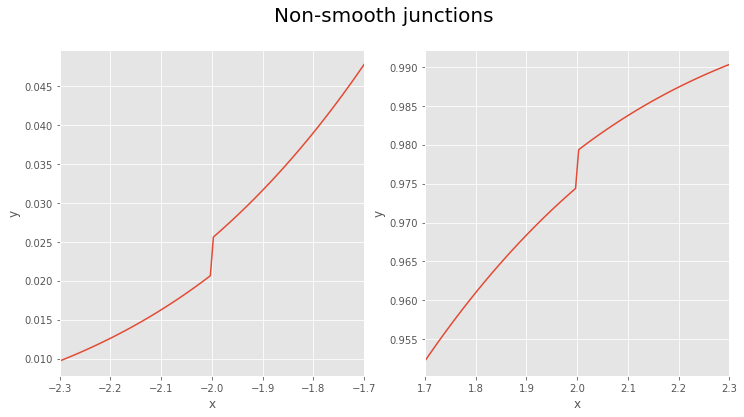

In [21]:
def guessed_error(x):
    return np.where(
        x > -2,
        -0.015 * np.exp(tanh_second_deriv(-x - 0.58)) + 0.015,
        0
    )
    
def cdf_approx_full(x):
    return np.where(
        x <= 0,
        np.clip(half_cdf_approx(x) + guessed_error(x), 0, 0.5),
        1 - np.clip(half_cdf_approx(-x) + guessed_error(-x), 0, 0.5)
    )

jump_points = [-2, 2]
region_edge_step = 0.3

fig, axes = plt.subplots(1, len(jump_points), figsize=(12, 6))
fig.suptitle("Non-smooth junctions", fontsize=20)

for ax, jump_point in zip(axes, jump_points):
    left_bound = jump_point - region_edge_step
    right_bound = jump_point + region_edge_step
    
    x = np.linspace(left_bound, right_bound, 100)
    y = cdf_approx_full(x)

    ax.set_xlim(left_bound, right_bound)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.plot(x, y)
    
plt.show()

The remaining problems are not really that big and CDF approximation gives us pretty good result. For simplicity we can ignore this problem.

Below I provided the entire formula for the CDF approximation.

$$
\Phi(x) =
\begin{cases}
\Phi _ {avg}(x) + r(x),  & \text{if $x \le 0$ and $\Phi _ {avg}(x) + r(x) < 0.5$} \\\\
1 - \Phi _ {avg}(-x) - r(-x),  & \text{if $x > 0$ and $\Phi _ {avg}(-x) + r(-x) < 0.5$} \\\\
0.5,  & \text{otherwise}
\end{cases}
\tag{25}
$$

where

$$
\begin{align}
&
\Phi _ {avg} (x) = \frac {2x + \sqrt{x ^ 2 + 2} + \sqrt{x ^ 2 + 2 \cdot ln(2)}} {2} \cdot f(x), & \text{for $x \le 0$}
\end{align}
$$

$$
f(x) = \frac{1}{\sqrt{2 \pi}} \cdot e ^ {\frac{-x ^ 2}{2}}
$$

$$
r(x) = -0.015 \cdot exp ^ {-2 \cdot tanh(-x - 0.58) \cdot sech ^ 2(-x - 0.58)} + 0.015
$$

Formula is definitely not among the simplest ones, but methods that produced it are simple and straightforward.